In [1]:
from icevision.all import *
import icedata

from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger

from fastai.vision.all import *
from fastai.callback.wandb import *

import wandb

from icevision_detector import *

In [2]:
path: Param("Training dataset path", str) = Path.home()/'Datasets/image/deepfashion/'
bs: Param("Batch size", int) = 24
log: Param("Log to wandb", bool) = False
num_workers: Param("Number of workers to use", int) = 4
resume: Param("Link to pretrained model", str) = None
name: Param('experiment name', str) = 'coco'

In [3]:
def deepfashion_dataset(
        root_dir:Union[Path, str],
        mask: bool = False,
        autofix: bool = True,
        cache_records: bool = True
) -> Tuple[tuple, ClassMap]:

    if isinstance(root_dir, str): root_dir = Path(root_dir)
    coco_train = icedata.coco.parser(
        img_dir=root_dir / 'train',
        annotations_file=root_dir / 'train/deepfashion2.json',
        mask=mask)

    coco_valid = icedata.coco.parser(
        img_dir=root_dir / 'validation',
        annotations_file=root_dir / 'validation/deepfashion2.json',
        mask=mask)

    train_records, *_ = coco_train.parse(data_splitter=SingleSplitSplitter(), autofix=autofix,
                                         cache_filepath=root_dir / 'train_cache' if cache_records else None)
    valid_records, *_ = coco_valid.parse(data_splitter=SingleSplitSplitter(), autofix=autofix,
                                         cache_filepath=root_dir / 'valid_cache' if cache_records else None)

    assert(coco_train.class_map==coco_valid.class_map), \
        f"ClassMap for train and valid differ: {coco_train.class_map=}!={coco_valid.class_map=}"
    return (train_records, valid_records), coco_train.class_map

In [4]:
(train_records, valid_records), class_map = deepfashion_dataset(path, autofix=True)

INFO     - Loading cached records from /home/ppotrykus/Datasets/image/deepfashion/train_cache | icevision.parsers.parser:parse:119
INFO     - Loading cached records from /home/ppotrykus/Datasets/image/deepfashion/valid_cache | icevision.parsers.parser:parse:119


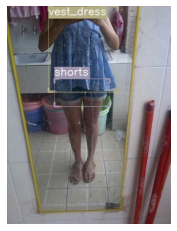

In [5]:
show_record(train_records[1], display_label=True, class_map=class_map)

In [6]:
size = 512
num_classes = len(class_map)
aug_tfms = tfms.A.aug_tfms(
    size=size,
    shift_scale_rotate=tfms.A.ShiftScaleRotate(rotate_limit=(-15, 15)),
    pad=partial(tfms.A.PadIfNeeded, border_mode=0)
)
aug_tfms.append(tfms.A.Normalize())

train_tfms = tfms.A.Adapter(aug_tfms)
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size), tfms.A.Normalize()])

train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

metrics = [COCOMetric(print_summary=True)]

In [7]:
train_dl = efficientdet.train_dl(train_ds, batch_size=bs, num_workers=num_workers, shuffle=True)
valid_dl = efficientdet.valid_dl(valid_ds, batch_size=bs, num_workers=num_workers, shuffle=False)

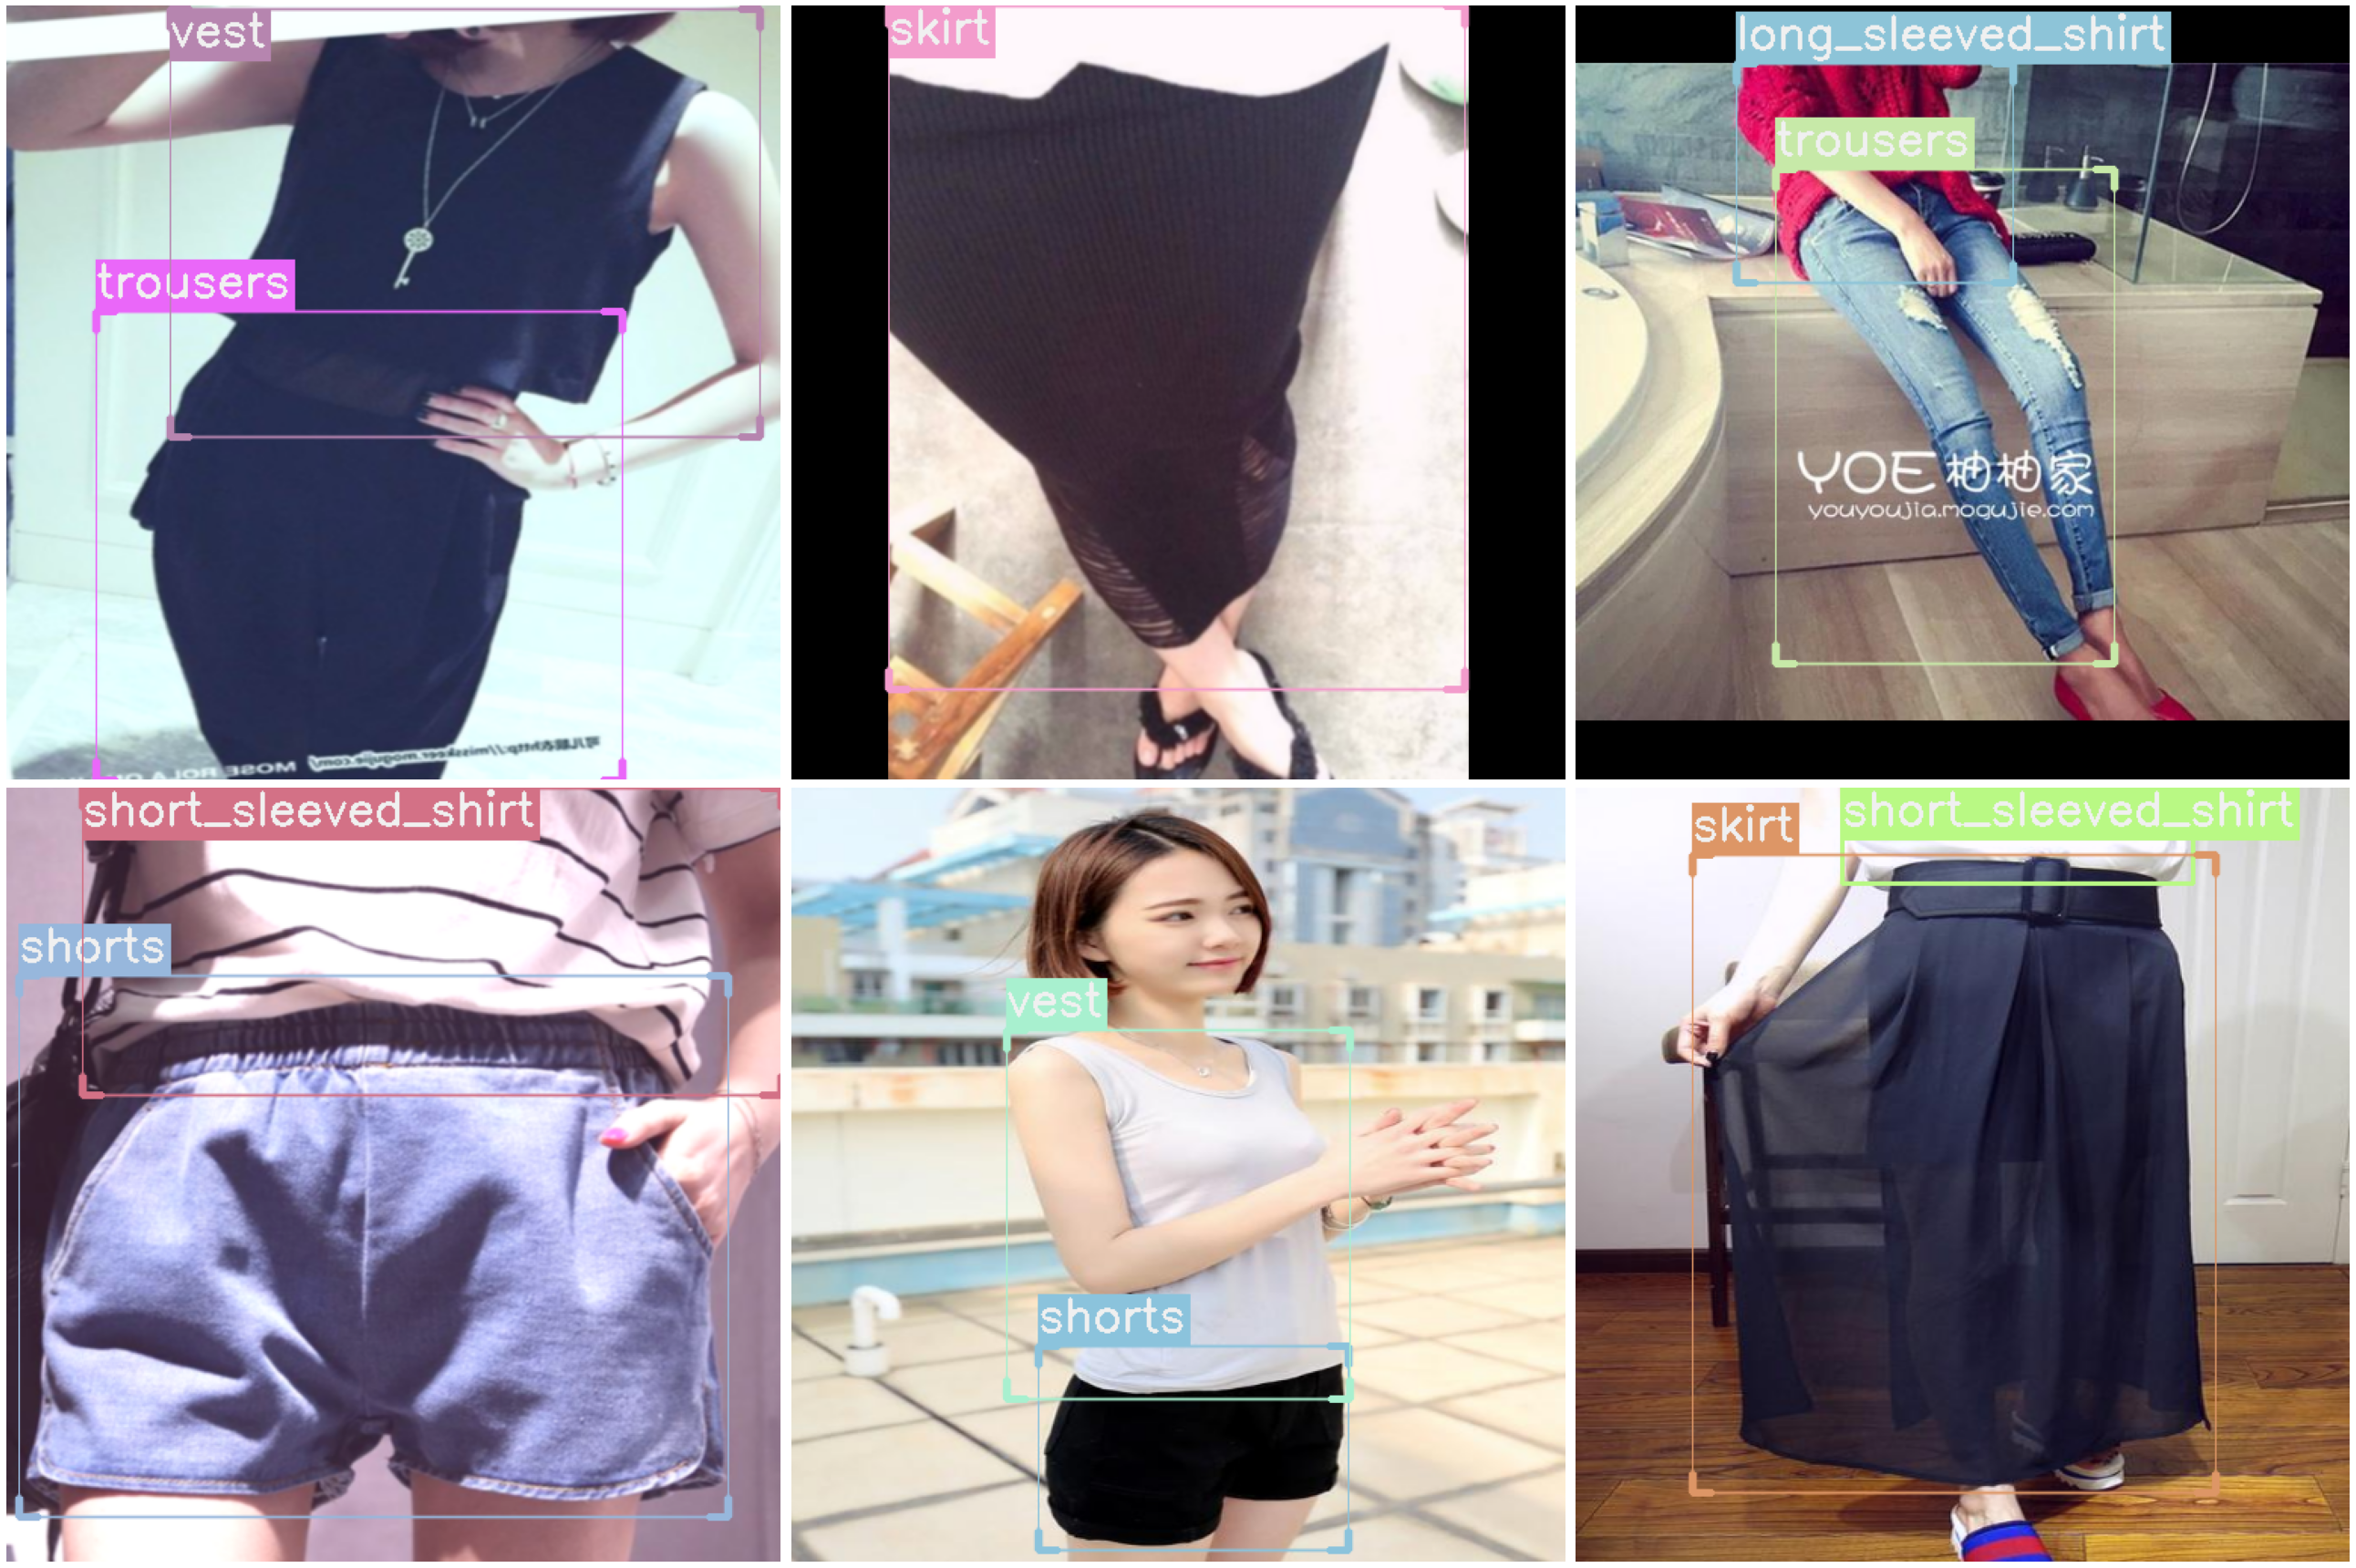

In [8]:
batch, samples = first(train_dl)
show_samples(samples[:6], class_map=class_map, ncols=3)

In [9]:
checkpoint_callback = ModelCheckpoint(
    verbose=True,
    monitor='COCOMetric/AP (IoU=0.50:0.95) area=all',
    mode='max')

lr_monitor = LearningRateMonitor(log_momentum=True)
wandb_logger = WandbLogger(project='deepfashion', offline=not log, name=name)

In [10]:
light_model = EffDetModel(
    num_classes=num_classes, img_size=size, model_name='tf_efficientdet_d3',
    lr=0.05, warmup_epochs=0,
)
light_model.freeze_to_head()

In [11]:
trainer = pl.Trainer(
    # num_sanity_val_steps=100,  # 1000 is enough to validate on all COCO @bs=8
    # limit_train_batches=10,
    # limit_val_batches=100,
    gpus=1,
    logger=wandb_logger,
    callbacks=[lr_monitor],
    max_epochs=100,
    sync_batchnorm=True,
    weights_summary='full',
    amp_level='O2', precision=16,
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.


In [12]:
halt

NameError: name 'halt' is not defined

In [13]:
trainer.fit(light_model, train_dl, valid_dl)

wandb: Offline run mode, not syncing to the cloud.
wandb: W&B syncing is set to `offline` in this directory.  Run `wandb online` to enable cloud syncing.

     | Name                                                          | Type                   | Params
------------------------------------------------------------------------------------------------------------
0    | model                                                         | DetBenchTrain          | 11.9 M
1    | model.model                                                   | EfficientDet           | 11.9 M
2    | model.model.backbone                                          | EfficientNetFeatures   | 10.1 M
3    | model.model.backbone.conv_stem                                | Conv2dSame             | 1.1 K 
4    | model.model.backbone.bn1                                      | BatchNorm2d            | 80    
5    | model.model.backbone.act1                                     | SiLU                   | 0     
6    | model.mo

Validation sanity check: 0it [00:00, ?it/s]

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000


/home/ppotrykus/anaconda3/envs/deepfashion/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.040
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.123
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.043
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.237
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.317
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.318
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.250
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.357
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.318


Validating: 0it [00:00, ?it/s]

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.044
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.137
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.048
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.245
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.324
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.325
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.250
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.340
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.325


Validating: 0it [00:00, ?it/s]

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.048
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.148
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.053
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.257
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.326
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.327
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.275
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.347
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.327


Validating: 0it [00:00, ?it/s]

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.049
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.151
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.055
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.246
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.324
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.300
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.354
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.324


Validating: 0it [00:00, ?it/s]

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.050
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.154
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.055
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.248
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.326
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.327
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.175
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.372
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.326


Validating: 0it [00:00, ?it/s]

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.053
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.155
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.019
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.059
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.263
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.334
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.335
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.250
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.368
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.335


/home/ppotrykus/anaconda3/envs/deepfashion/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

In [14]:
wandb.run.finish()

wandb: You can sync this run to the cloud by running:
wandb: wandb sync /home/ppotrykus/Programs/deepfashion/wandb/offline-run-20210208_135119-26ebogu6
